# Pronóstico de la evolución de pacientes con diabetes

## Descripción del problema real

Los tratamientos médicos están basados en las expectativas de recuperación o el avance de una enfermedad para tomar decisiones. En este caso, un equipo médico desea contar con pronósticos de pacientes con diabetes para tomar decisiones sobre su tratamiento.

## Descripción del problema en términos de los datos

Se desea determinar el progreso de la diabeteis un año hacia adelante a partir de las variables medidas para 442 pacientes. La información está almacenada en el archivo `datos/diabetes.csv`. Las variables medidas son: edad, sexo, indice de masa corporal, presión sanguinea y seis medidas de serum en la sangre. Se desea pronósticar el progreso de la enfermedad a partir de las variables dadas.

## Aproximaciones posibles

En este caso, se desea comparar los resultados de un modelo de regresión lineal y un modelo de redes neuronales artificiales.

## Requerimientos

Usted debe:

* Determinar cuáles de las variables consideradas son relevantes para el problema.


* Determinar si hay alguna transformación de las variables de entrada o de salida que mejore el pronóstico del modelo.


* Construir un modelo de regresión lineal que sirva como base para construir un modelo de redes neuronales artificiales.



* Construir un modelo de redes neuronales artificiales. Asimismo, debe determinar el número de neuronas en la capa o capas ocultas.


* Utiizar una técnica como crossvalidation u otra similar para establecer la robustez del modelo.

# Solucion

In [1]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
dataset = pd.read_csv('datos/diabetes.csv')

In [3]:
#datos y clases
X = dataset.drop('Y', axis = 'columns')
Y = dataset['Y']

In [4]:
#algorritmo backwards
#Akaike Information Criteria

def backwards(X,Y):
    
    model = sm.OLS(Y,X)
    results = model.fit()
    current_aic = results.aic
    smallest_drop = ('',current_aic)
    dropped = False
    
    while(True):
        
        for col in X.columns:
            
            model = sm.OLS(Y,X.drop(col,axis=1))
            results = model.fit()
#             print(results.aic)
            if results.aic < smallest_drop[1]:
                smallest_drop = (col,results.aic)
                dropped = True
        
        if not dropped:
            return X
            break
        X = X.drop(smallest_drop[0],axis=1)
        dropped = False


In [5]:
#algoritmo forward
#Akaike Informacion Criteria

def forward(X,Y):
    
    read = []
    dropped = False
    
    columns = list(X.columns)
    
    model = sm.OLS(Y,X[columns[0]])
    results = model.fit()
    smallest_drop = (columns[0],results.aic)
    
    for col in columns[1:]:
        
        model = sm.OLS(Y,X[col])
        results = model.fit()
        if results.aic < smallest_drop[1]:
            smallest_drop = (col,results.aic)
    
    read.append(smallest_drop[0])
    columns.remove(smallest_drop[0])
    
    
    while(True):
        
        for col in columns:
            
            if not col in read:
            
                to_read = read.copy()
                to_read.append(col)
                model = sm.OLS(Y,X[to_read])
                results = model.fit()
                if results.aic < smallest_drop[1]:
                    smallest_drop = (to_read,results.aic)
                    dropped = True
        
        if not dropped:
            return X[read]
            break
        read = smallest_drop[0].copy()
        dropped = False
                    

In [6]:
#variables seleccionadas
forw = forward(X,Y)
backw = backwards(X,Y)
print(forw.columns)
print(backw.columns)

Index(['bmi', 's5', 'bp'], dtype='object')
Index(['bmi', 'bp', 's5'], dtype='object')


In [7]:
selected_variables = list(backw.columns)

## Regresion Lineal

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [9]:
xtrain, xtest, ytrain, ytest = train_test_split(X[selected_variables],
                                               Y,
                                               test_size=0.3,
                                               random_state=69420)

lin_regression = LinearRegression()

lin_regression.fit(xtrain,ytrain)

prediction = lin_regression.predict(xtest)

print('Error cuadrado regresion lineal:',
      metrics.mean_squared_error(ytest,prediction))

Error cuadrado regresion lineal: 2985.9339916862828


In [10]:
#busqueda de splitsize
def linreg_test_size_opt(X,Y):
    
    sizes = [0.2,0.25,0.3,0.35,0.4]
    errors = []
    model = LinearRegression()
    
    for size in sizes:
    
        xtrain, xtest, ytrain, ytest = train_test_split(X[selected_variables],
                                                   Y,
                                                   test_size=size,
                                                   random_state=69420)
        model.fit(xtrain,ytrain)
        prediction = model.predict(xtest)
        errors.append(metrics.mean_squared_error(ytest,prediction))

    return sizes[errors.index(min(errors))], min(errors)
    

In [11]:
selected_size, error = linreg_test_size_opt(X,Y)
print('--------Regresion Lineal--------')
print(f'Tamano de muestra de prueba: {selected_size}\nError cuadrado: {error}')

--------Regresion Lineal--------
Tamano de muestra de prueba: 0.35
Error cuadrado: 2877.9363071991634


## Red neuronal

In [12]:
#NN

#separar datos de entrenamiento/evaluacion
xtrain, xtest, ytrain, ytest = train_test_split(X,
                                               Y,
                                               test_size=selected_size,
                                               random_state=69420)


feature_cols = [tf.feature_column.numeric_column(col) for col in X[selected_variables].columns]

train_input = tf.compat.v1.estimator.inputs.pandas_input_fn(x = xtrain,
                                                 y = ytrain,
                                                 batch_size=10,
                                                 num_epochs=2000,
                                                 shuffle=True)

#neuronas por capa
neurons = [2,4,8,16,32,64,128]
errors = []

for neuron in neurons:
    
    model = tf.estimator.DNNRegressor(hidden_units=[neuron],
                                     feature_columns=feature_cols)
    model.train(input_fn=train_input,steps=5000)
    
    test_input = tf.compat.v1.estimator.inputs.pandas_input_fn(x=xtest,
                                                              batch_size=10,
                                                              num_epochs=1,
                                                              shuffle=False)
    
    tests = []
    
    for prediction in list(model.predict(test_input)):
        tests.append(prediction['predictions'])
    
    errors.append(metrics.mean_squared_error(tests,ytest))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Mirai\\AppData\\Local\\Temp\\tmpedx2_371', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
I

INFO:tensorflow:loss = 37528.88, step = 4000 (0.224 sec)
INFO:tensorflow:global_step/sec: 425.629
INFO:tensorflow:loss = 31257.818, step = 4100 (0.239 sec)
INFO:tensorflow:global_step/sec: 446.427
INFO:tensorflow:loss = 22003.152, step = 4200 (0.224 sec)
INFO:tensorflow:global_step/sec: 429.088
INFO:tensorflow:loss = 20114.734, step = 4300 (0.237 sec)
INFO:tensorflow:global_step/sec: 446.52
INFO:tensorflow:loss = 41284.996, step = 4400 (0.218 sec)
INFO:tensorflow:global_step/sec: 438.607
INFO:tensorflow:loss = 25316.676, step = 4500 (0.230 sec)
INFO:tensorflow:global_step/sec: 438.571
INFO:tensorflow:loss = 34320.867, step = 4600 (0.228 sec)
INFO:tensorflow:global_step/sec: 423.752
INFO:tensorflow:loss = 34405.805, step = 4700 (0.233 sec)
INFO:tensorflow:global_step/sec: 411.525
INFO:tensorflow:loss = 27578.084, step = 4800 (0.244 sec)
INFO:tensorflow:global_step/sec: 444.323
INFO:tensorflow:loss = 22877.936, step = 4900 (0.225 sec)
INFO:tensorflow:Saving checkpoints for 5000 into C:\U

INFO:tensorflow:loss = 35747.695, step = 4100 (0.230 sec)
INFO:tensorflow:global_step/sec: 413.371
INFO:tensorflow:loss = 23941.012, step = 4200 (0.237 sec)
INFO:tensorflow:global_step/sec: 425.534
INFO:tensorflow:loss = 31215.73, step = 4300 (0.235 sec)
INFO:tensorflow:global_step/sec: 423.732
INFO:tensorflow:loss = 32734.27, step = 4400 (0.236 sec)
INFO:tensorflow:global_step/sec: 454.435
INFO:tensorflow:loss = 28161.156, step = 4500 (0.221 sec)
INFO:tensorflow:global_step/sec: 429.282
INFO:tensorflow:loss = 21074.422, step = 4600 (0.231 sec)
INFO:tensorflow:global_step/sec: 420.169
INFO:tensorflow:loss = 35634.707, step = 4700 (0.238 sec)
INFO:tensorflow:global_step/sec: 462.958
INFO:tensorflow:loss = 30123.316, step = 4800 (0.221 sec)
INFO:tensorflow:global_step/sec: 416.576
INFO:tensorflow:loss = 23775.234, step = 4900 (0.240 sec)
INFO:tensorflow:Saving checkpoints for 5000 into C:\Users\Mirai\AppData\Local\Temp\tmpaeegbdfp\model.ckpt.
INFO:tensorflow:Loss for final step: 30498.26

INFO:tensorflow:loss = 33017.76, step = 4200 (0.216 sec)
INFO:tensorflow:global_step/sec: 446.345
INFO:tensorflow:loss = 42914.527, step = 4300 (0.224 sec)
INFO:tensorflow:global_step/sec: 423.709
INFO:tensorflow:loss = 24767.184, step = 4400 (0.235 sec)
INFO:tensorflow:global_step/sec: 467.289
INFO:tensorflow:loss = 34540.42, step = 4500 (0.214 sec)
INFO:tensorflow:global_step/sec: 444.549
INFO:tensorflow:loss = 28458.65, step = 4600 (0.227 sec)
INFO:tensorflow:global_step/sec: 418.411
INFO:tensorflow:loss = 35118.457, step = 4700 (0.237 sec)
INFO:tensorflow:global_step/sec: 448.429
INFO:tensorflow:loss = 19845.736, step = 4800 (0.224 sec)
INFO:tensorflow:global_step/sec: 452.399
INFO:tensorflow:loss = 49222.613, step = 4900 (0.223 sec)
INFO:tensorflow:Saving checkpoints for 5000 into C:\Users\Mirai\AppData\Local\Temp\tmpenk0bm1m\model.ckpt.
INFO:tensorflow:Loss for final step: 34408.773.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely i

INFO:tensorflow:loss = 28590.395, step = 4300 (0.238 sec)
INFO:tensorflow:global_step/sec: 429.187
INFO:tensorflow:loss = 23940.555, step = 4400 (0.232 sec)
INFO:tensorflow:global_step/sec: 398.349
INFO:tensorflow:loss = 33392.15, step = 4500 (0.253 sec)
INFO:tensorflow:global_step/sec: 400.058
INFO:tensorflow:loss = 24283.86, step = 4600 (0.253 sec)
INFO:tensorflow:global_step/sec: 343.642
INFO:tensorflow:loss = 26441.15, step = 4700 (0.291 sec)
INFO:tensorflow:global_step/sec: 427.345
INFO:tensorflow:loss = 35359.355, step = 4800 (0.230 sec)
INFO:tensorflow:global_step/sec: 396.829
INFO:tensorflow:loss = 34179.688, step = 4900 (0.254 sec)
INFO:tensorflow:Saving checkpoints for 5000 into C:\Users\Mirai\AppData\Local\Temp\tmp7yd9j5qf\model.ckpt.
INFO:tensorflow:Loss for final step: 33355.97.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlo

INFO:tensorflow:loss = 22787.89, step = 4400 (0.247 sec)
INFO:tensorflow:global_step/sec: 414.924
INFO:tensorflow:loss = 34917.992, step = 4500 (0.244 sec)
INFO:tensorflow:global_step/sec: 380.24
INFO:tensorflow:loss = 22210.967, step = 4600 (0.262 sec)
INFO:tensorflow:global_step/sec: 374.533
INFO:tensorflow:loss = 25228.02, step = 4700 (0.264 sec)
INFO:tensorflow:global_step/sec: 398.397
INFO:tensorflow:loss = 23484.44, step = 4800 (0.252 sec)
INFO:tensorflow:global_step/sec: 383.151
INFO:tensorflow:loss = 28939.738, step = 4900 (0.261 sec)
INFO:tensorflow:Saving checkpoints for 5000 into C:\Users\Mirai\AppData\Local\Temp\tmpvg0ruhm2\model.ckpt.
INFO:tensorflow:Loss for final step: 22196.953.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras

INFO:tensorflow:global_step/sec: 377.349
INFO:tensorflow:loss = 15385.453, step = 4300 (0.262 sec)
INFO:tensorflow:global_step/sec: 343.649
INFO:tensorflow:loss = 16873.988, step = 4400 (0.288 sec)
INFO:tensorflow:global_step/sec: 413.227
INFO:tensorflow:loss = 38014.258, step = 4500 (0.245 sec)
INFO:tensorflow:global_step/sec: 396.814
INFO:tensorflow:loss = 25291.76, step = 4600 (0.252 sec)
INFO:tensorflow:global_step/sec: 425.537
INFO:tensorflow:loss = 34089.656, step = 4700 (0.235 sec)
INFO:tensorflow:global_step/sec: 378.794
INFO:tensorflow:loss = 20979.152, step = 4800 (0.263 sec)
INFO:tensorflow:global_step/sec: 404.772
INFO:tensorflow:loss = 27362.568, step = 4900 (0.246 sec)
INFO:tensorflow:Saving checkpoints for 5000 into C:\Users\Mirai\AppData\Local\Temp\tmpm1s4ry1o\model.ckpt.
INFO:tensorflow:Loss for final step: 38779.46.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely o

INFO:tensorflow:loss = 12603.716, step = 4400 (0.228 sec)
INFO:tensorflow:global_step/sec: 421.846
INFO:tensorflow:loss = 21587.406, step = 4500 (0.238 sec)
INFO:tensorflow:global_step/sec: 450.555
INFO:tensorflow:loss = 14759.096, step = 4600 (0.223 sec)
INFO:tensorflow:global_step/sec: 411.523
INFO:tensorflow:loss = 22064.77, step = 4700 (0.240 sec)
INFO:tensorflow:global_step/sec: 469.483
INFO:tensorflow:loss = 28690.777, step = 4800 (0.214 sec)
INFO:tensorflow:global_step/sec: 438.496
INFO:tensorflow:loss = 22706.09, step = 4900 (0.228 sec)
INFO:tensorflow:Saving checkpoints for 5000 into C:\Users\Mirai\AppData\Local\Temp\tmp0rwcu8p0\model.ckpt.
INFO:tensorflow:Loss for final step: 22632.484.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.ker

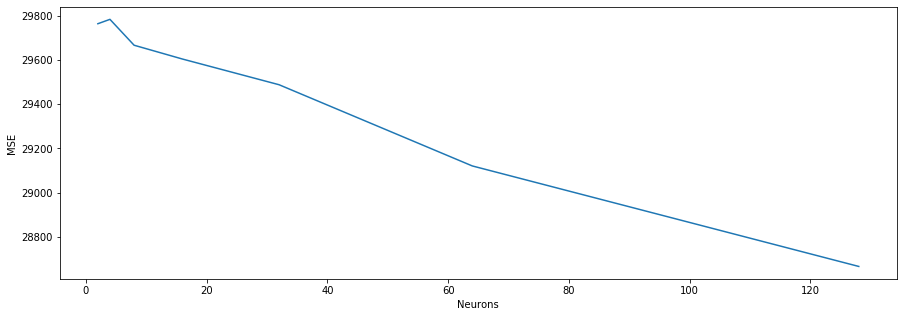

In [13]:
plt.figure(figsize=(15,5))
plt.xlabel('Neurons')
plt.ylabel("MSE")
plt.plot(neurons,errors)

In [14]:
neurons_per_layer=neurons[errors.index(min(errors))]
print(f'Neuronas por capa: {neurons_per_layer}')

Neuronas por capa: 128


In [15]:
#numero de capas
layers = [[128],
         [128,128],
         [128,128,128],
         [128,128,128,128],
         [128,128,128,128,128]]

errors_layers = []

for layer in layers:
    
    model = tf.estimator.DNNRegressor(hidden_units=layer,
                                     feature_columns = feature_cols)
    model.train(input_fn=train_input,steps=5000)
    
    test_input = tf.compat.v1.estimator.inputs.pandas_input_fn(x=xtest,
                                                              batch_size=10,
                                                              num_epochs=1,
                                                              shuffle=False)
    
    predictions = []
    
    for predict in list(model.predict(test_input)):
        predictions.append(predict['predictions'])
    
    errors_layers.append(metrics.mean_squared_error(predictions,ytest))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Mirai\\AppData\\Local\\Temp\\tmpw7yoq46m', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, y

INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Mirai\\AppData\\Local\\Temp\\tmpgjyhsfca', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If 

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\Mirai\AppData\Local\Temp\tmpor9bdhjn\model.ckpt.
INFO:tensorflow:loss = 47730.4, step = 0
INFO:tensorflow:global_step/sec: 255.102
INFO:tensorflow:loss = 44329.64, step = 100 (0.391 sec)
INFO:tensorflow:global_step/s

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\Mirai\AppData\Local\Temp\tmp8y10ms2q\model.ckpt.
INFO:tensorflow:loss = 28872.688, step = 0
INFO:tensorflow:global_step/sec: 306.48
INFO:tensorflow:loss = 28804.45, step = 100 (0.328 sec)
INFO:tensorflow:global_step/sec: 382.11
INFO:tensorflow:loss = 22783.748, step = 200 (0.261 sec)
INFO:tensorflow:global_step/sec: 394.901
INFO:tensorflow:loss = 4579.0425, step = 300 (0.252 sec)
INFO:tensorflow:global_step/sec: 369.004
INFO:tensorflow:loss = 5576.5376, step = 400 (0.272 sec)
INFO:tensorflow:global_step/sec: 341.297
INFO:tensorflow:loss = 5027.9575, step = 500 (0.293 sec)
INFO:tensorflow:global_step/sec: 358.415
INFO:tensorflow:loss = 4728.052, step = 600 (0.279 sec)
INFO:tensorflow:global_step/sec: 350.884
INFO:tensorflow:loss = 47

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\Mirai\AppData\Local\Temp\tmpcb2ca48k\model.ckpt.
INFO:tensorflow:loss = 28840.463, step = 0
INFO:tensorflow:global_step/sec: 296.736
INFO:tensorflow:loss = 17274.01, step = 100 (0.337 sec)
INFO:tensorflow:global_step/sec: 381.604
INFO:tensorflow:loss = 16174.581, step = 200 (0.260 sec)
INFO:tensorflow:global_step/sec: 383.219
INFO:tensorflow:loss = 7721.452, step = 300 (0.263 sec)
INFO:tensorflow:global_step/sec: 384.615
INFO:tensorflow:loss = 2824.7559, step = 400 (0.259 sec)
INFO:tensorflow:global_step/sec: 388.938
INFO:tensorflow:loss = 5914.7236, step = 500 (0.258 sec)
INFO:tensorflow:global_step/sec: 370.521
INFO:tensorflow:loss = 4719.8096, step = 600 (0.269 sec)
INFO:tensorflow:global_step/sec: 294.985
INFO:tensorflow:loss = 6720.5674, step = 700 (0.340 sec)
INFO:tensorflow:global_step/sec: 360.898
INFO:tensorflow:loss = 4333.8604, step = 800 

In [16]:
model_layers = layers[errors_layers.index(min(errors_layers))]

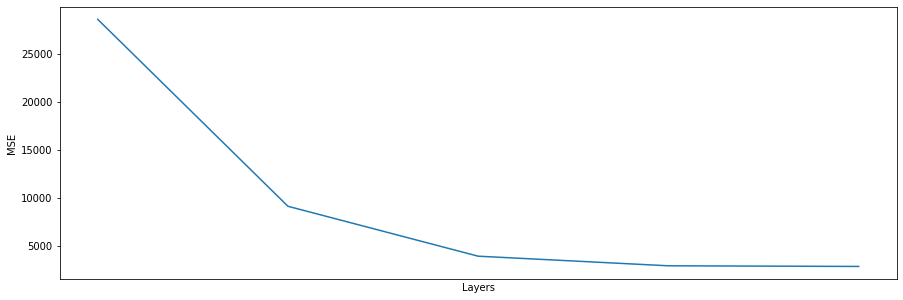

In [25]:
plt.figure(figsize=(15,5))
plt.xlabel('Layers')
plt.ylabel("MSE")
plt.xticks(model_layers)
plt.plot([len(x) for x in layers],errors_layers)

In [18]:
final_errors = []

#final model

model = tf.estimator.DNNRegressor(hidden_units=model_layers,
                                 feature_columns=feature_cols)
model.train(input_fn=train_input,steps=5000)
test_input = tf.compat.v1.estimator.inputs.pandas_input_fn(x=xtest,
                                                          batch_size=10,
                                                          num_epochs=1,
                                                          shuffle=False)
predictions = []
    
for predict in list(model.predict(test_input)):
    predictions.append(predict['predictions'])

final_errors.append(metrics.mean_squared_error(predictions,ytest))    

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Mirai\\AppData\\Local\\Temp\\tmpq523l_l2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, y

In [19]:
print(f'MSE para red 128 neuronas por capa, 5 capas:\n{final_errors}')

MSE para red 128 neuronas por capa, 5 capas:
[2840.403941232526]


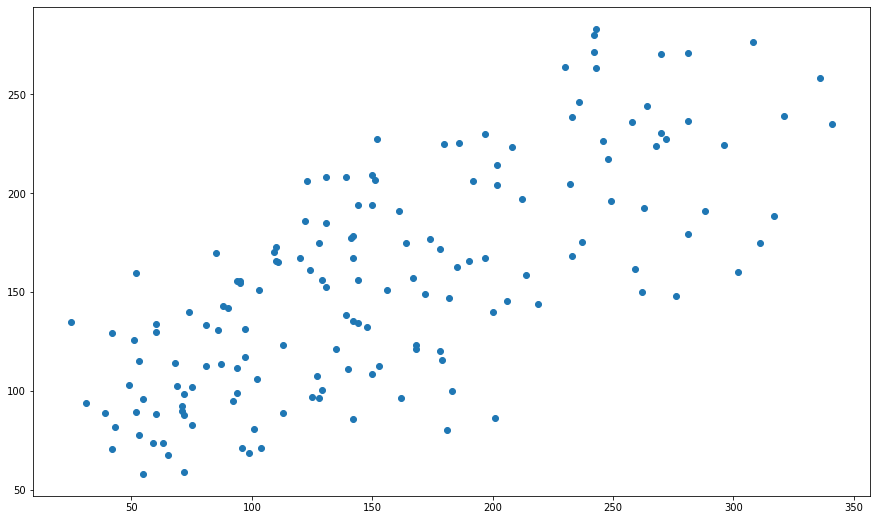

In [20]:
plt.figure(figsize=(15,9))
plt.scatter(ytest,predictions)

In [21]:
from sklearn.model_selection import KFold

def x_validation(train_index,test_index,X,Y):
    
    xtrain = X.iloc[train_index,:]
    xtest = X.iloc[test_index,:]
    ytrain = Y.iloc[train_index]
    ytest = Y.iloc[test_index]
    
    train_input = tf.compat.v1.estimator.inputs.pandas_input_fn(x=xtrain,
                                                               y=ytrain,
                                                               batch_size=10,
                                                               num_epochs=2000,
                                                               shuffle=True)
    
    model = tf.estimator.DNNRegressor(hidden_units=model_layers,
                                     feature_columns=feature_cols)
    model.train(input_fn=train_input,steps=5000)
    
    test_input = tf.compat.v1.estimator.inputs.pandas_input_fn(x=xtest,
                                                              batch_size=10,
                                                              num_epochs=1,
                                                              shuffle=False)
    predictions = []
    
    for predict in list(model.predict(test_input)):
        predictions.append(predict['predictions'])
    
    return metrics.mean_squared_error(predictions,ytest)
    
kf = KFold(n_splits=4)

x_val = []

for train_index,test_index in kf.split(X):
    x_val.append(x_validation(train_index,test_index,X[selected_variables],Y))


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Mirai\\AppData\\Local\\Temp\\tmpy1xy5sna', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, y

INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Mirai\\AppData\\Local\\Temp\\tmphybs3t73', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If 

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\Mirai\AppData\Local\Temp\tmpdnweoycu\model.ckpt.
INFO:tensorflow:loss = 29117.572, step = 0
INFO:tensorflow:global_step/sec: 373.135
INFO:tensorflow:loss = 18275.113, step = 100 (0.269 sec)
INFO:tensorflow:global_ste

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\Mirai\AppData\Local\Temp\tmpfycrxla8\model.ckpt.
INFO:tensorflow:loss = 26026.188, step = 0
INFO:tensorflow:global_step/sec: 371.746
INFO:tensorflow:loss = 24417.83, step = 100 (0.270 sec)
INFO:tensorflow:global_step/sec: 523.563
INFO:tensorflow:loss = 7741.4165, step = 200 (0.190 sec)
INFO:tensorflow:global_step/sec: 537.633
INFO:tensorflow:loss = 2441.827, step = 300 (0.186 sec)
INFO:tensorflow:global_step/sec: 526.317
INFO:tensorflow:loss = 5995.3975, step = 400 (0.191 sec)
INFO:tensorflow:global_step/sec: 520.831
INFO:tensorflow:loss = 2183.9524, step = 500 (0.192 sec)
INFO:tensorflow:global_step/sec: 520.833
INFO:tensorflow:loss = 2329.1648, step = 600 (0.192 sec)
INFO:tensorflow:global_step/sec: 515.464
INFO:tensorflow:loss = 

In [22]:
print(f'Cross Validation MSE: {sum(x_val)/len(x_val)}')

Cross Validation MSE: 3078.9185586942413


## Conclusiones

Despues de obtener los datos, se realiza la busqueda de las variables relevantes utlizando el AIC (Akaike Information Criteria) y evaluando con un algoritmo forward y backward. Para ambos casos las caracteristicas seleccionadas son s5, bmi y bp. Considerando que el indice de masa corporal (bmi - body mass index) y la presion sanguinea (bp - blood pressure) estan incluidas para un analisis de diabetes, se procede con estas caracteristicas.

La regresion lineal muestra una mediia de error cuadrado (MSE) menor que el promedio de el MSE de la red neuronal al ejecutar validacion cruzada. Esto indica que con 128 neuronas por capa en 5 capas, la regresion lineal es mejor.
No obstante, aunque el numero de capas se observa que no brindaria una mejor precision, para el numero de neuronas, segun el estudio realizado, aun se observa que es posible mejorar el resultado aumentando el numero de neuronas. Aun asi se considera que la divergencia de los datos, basado en el MSE, es muy alta.